In [5]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK data (if needed)
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Load the dataset
df = pd.read_csv('data/mental_health.csv')

# List to store indices of changed rows
changed_indices = []

# Function to perform lemmatization
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply lemmatization and remove 'filler' if it appears more than twice
for idx, row in df.iterrows():
    original_text = row['text']
    
    # Lemmatize text
    lemmatized_text = lemmatize_text(original_text)
    
    # Count occurrences of the word "filler"
    filler_count = lemmatized_text.lower().count("filler")
    
    # If 'filler' appears more than twice, remove all instances of it
    if filler_count > 2:
        lemmatized_text = re.sub(r'\bfiller\b', '', lemmatized_text, flags=re.IGNORECASE)
        lemmatized_text = re.sub(r'\s+', ' ', lemmatized_text).strip()  # Remove extra spaces

    # Check if the text was changed
    if original_text != lemmatized_text:
        df.at[idx, 'text'] = lemmatized_text
        changed_indices.append(idx)

# Remove rows with only whitespace or empty strings
df = df[df['text'].str.strip() != '']

# Save the updated dataset
df.to_csv('data/lemm/lem_mhc.csv', index=False)

# Save changed indices for confirmation
with open('data/lemm/changed_indices.txt', 'w') as f:
    for idx in changed_indices:
        f.write(f"{idx}\n")

# Output the number of changed rows and total rows after cleanup
print(f"Lemmatization and 'filler' removal applied to {len(changed_indices)} rows.")
print(f"Total rows after cleanup: {len(df)}")
print(f"Changed indices saved to 'data/lemm/changed_indices.txt'.")

Lemmatization and 'filler' removal applied to 23808 rows.
Total rows after cleanup: 27975
Changed indices saved to 'data/lemm/changed_indices.txt'.


In [4]:
import pandas as pd
from gensim.models import Word2Vec

# Load the data
file_path = 'data/lemm/lem_mhc.csv'  # Adjust to your local path
data = pd.read_csv(file_path)

# Tokenizing the 'text' column for Word2Vec
# Assuming text is already lemmatized, split text into list of words
data['tokenized_text'] = data['text'].apply(lambda x: x.split())

# Train a Word2Vec model (Skip-gram)
model = Word2Vec(
    sentences=data['tokenized_text'], 
    vector_size=100,  # Embedding dimension
    window=5,         # Context window size
    sg=1,             # Skip-gram model
    min_count=5,      # Minimum word frequency threshold
    workers=4         # Parallelization for faster training
)

# Define keywords for each topic
keywords = {
    'mention_of_emotion': ['happy', 'sad', 'angry', 'fear', 'joy', 'emotion'],
    'mention_of_substance': ['alcohol', 'drugs', 'substance', 'addiction', 'cocaine', 'heroin'],
    'mention_of_manic': ['manic', 'mania', 'hypomania', 'panic'],
    'mention_of_crime': ['crime', 'criminal', 'theft', 'robbery', 'assault'],
    'mention_of_selfharm': ['selfharm', 'cutting', 'suicide', 'suicidal', 'harm', 'kill'],
    'mention_of_hospitalization': ['hospital', 'hospitalization', 'inpatient', 'admission'],
    'mention_of_societal': ['society', 'societal', 'community', 'norm', 'culture'],
    'mention_of_therapy': ['therapy', 'counseling', 'counselor', 'psychotherapy', 'therapist'],
    'mention_of_violence': ['violence', 'abuse', 'aggression', 'assault', 'fight', 'kill'],
    'mention_of_isolation': ['isolation', 'lonely', 'alone', 'solitary', 'secluded']
}

# Expand each topic's dictionary with similar words
expanded_keywords = {}

for topic, words in keywords.items():
    similar_words = set()
    for word in words:
        if word in model.wv:  # Check if word exists in vocabulary
            # Get the top 10 most similar words
            similar = model.wv.most_similar(word, topn=10)
            similar_words.update([sim[0] for sim in similar])
    
    # Combine the original words with the similar words
    expanded_keywords[topic] = list(set(words).union(similar_words))

# Output expanded keyword dictionary
for topic, words in expanded_keywords.items():
    print(f"\nExpanded keywords for {topic}:")
    print(words)

# Save the expanded dictionary to a file if needed
expanded_keywords_df = pd.DataFrame.from_dict(expanded_keywords, orient='index').transpose()
expanded_keywords_df.to_csv('data/w2v_exp/expanded_keywords.csv', index=False)


Expanded keywords for mention_of_emotion:
['emotion', 'sad', 'angry', 'lonely', 'anger', 'frustration', 'happy', 'overwhelmingly', 'enjoyment', 'carefree', 'heartbroken', 'pleasure', 'heh', 'sadi', 'lash', 'insecurity', 'humiliation', 'mad', 'violated', 'excitement', 'illusion', 'annoyed', 'dissapointed', 'grieving', 'uncertainty', 'afraid', 'sadder', 'frustrated', 'unfulfilled', 'joy', 'happiness', 'regret', 'fulfilled', 'hopelessness', 'emptiness', 'persevere', 'scared', 'yelled', 'upset', 'satisfaction', 'roller', 'distraction', 'joyful', 'unhappiness', 'confusion', 'irritated', 'fear', 'happyi', 'happier', 'lonelyi', 'bliss', 'fulfillment', 'bottled', 'coaster', 'pissed', 'sadness', 'devoid', 'loneliness', 'repercussion']

Expanded keywords for mention_of_substance:
['nicotine', 'poisoning', 'dependency', 'drugs', 'marijuana', 'diazepam', 'addiction', 'drug', 'oxycodone', 'deformity', 'gambling', 'fentanyl', 'lexapro', 'overdose', 'repetition', 'paracetamol', 'ambien', 'sertraline

In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import words, stopwords

# Make sure to download the required NLTK resources
nltk.download('words')
nltk.download('stopwords')

# Load the dataset
df = pd.read_csv('data/lemm/lem_mhc.csv')

# Load the word list from NLTK
english_words = set(words.words())
stop_words = set(stopwords.words('english'))

# Function to count words
def word_count(text):
    return len(text.split())

# Function to count suspected spelling errors
def suspected_spell_err(text):
    tokens = text.split()
    return sum(1 for word in tokens if word not in english_words)

# Function to count first-person pronouns using NLTK stopwords for bias reduction
def num_first_person_use(text):
    first_person_pronouns = {"i", "me", "my", "mine", "we", "us", "our", "ours"}
    tokens = text.lower().split()
    return sum(1 for word in tokens if word in first_person_pronouns)

# Function to count third-person pronouns
def num_third_person_use(text):
    third_person_pronouns = {"he", "him", "his", "she", "her", "hers", "they", "them", "their", "theirs"}
    tokens = text.lower().split()
    return sum(1 for word in tokens if word in third_person_pronouns)

# Apply the functions to the 'text' column
df['word_count'] = df['text'].apply(word_count)
df['suspected_spell_err'] = df['text'].apply(suspected_spell_err)
df['num_first_person_use'] = df['text'].apply(num_first_person_use)
df['num_third_person_use'] = df['text'].apply(num_third_person_use)

# Save the updated dataframe to a new CSV
df.to_csv('data/lemm/lem_mhc_updated_1.csv', index=False)

# Show the first few rows
print(df.head())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\duy68\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duy68\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  label  word_count  \
0  dear american teen question dutch person heard...      0          23   
1  nothing look forward lifei dont many reason ke...      1          20   
2  music recommendation im looking expand playlis...      0          64   
3  im done trying feel betterthe reason im still ...      1         100   
4  worried year old girl subject domestic physica...      1         311   

   suspected_spell_err  num_first_person_use  num_third_person_use  
0                    4                     0                     0  
1                    2                     0                     0  
2                   14                     0                     0  
3                   20                     0                     0  
4                   36                     0                     6  


In [9]:
import pandas as pd

# Load the main dataset and keywords
df = pd.read_csv('data/lemm/lem_mhc_updated_1.csv')
keywords_df = pd.read_csv('data/w2v_exp/corrected-keywords.csv')

# Convert keywords in each column to lowercase for consistency
keywords_df = keywords_df.apply(lambda col: col.str.lower())

# Function to count occurrences of specific keywords in text
def count_keywords(text, keyword_list):
    tokens = text.lower().split()  # Tokenize the text and convert to lowercase
    keyword_set = set(keyword_list.dropna())  # Drop NaN values and convert to set for faster lookups
    return sum(1 for word in tokens if word in keyword_set)

# Iterate over each keyword column from the keywords file and create corresponding count columns in the main dataset
for column in keywords_df.columns:
    df[column] = df['text'].apply(lambda text: count_keywords(text, keywords_df[column]))

# Save the updated dataframe to a new CSV file
df.to_csv('data/lemm/lem_mhc_updated_2.csv', index=False)

# Display the first few rows of the updated dataframe to verify
print(df.head())

                                                text  label  word_count  \
0  dear american teen question dutch person heard...      0          23   
1  nothing look forward lifei dont many reason ke...      1          20   
2  music recommendation im looking expand playlis...      0          64   
3  im done trying feel betterthe reason im still ...      1         100   
4  worried year old girl subject domestic physica...      1         311   

   suspected_spell_err  num_first_person_use  num_third_person_use  \
0                    4                     0                     0   
1                    2                     0                     0   
2                   14                     0                     0   
3                   20                     0                     0   
4                   36                     0                     6   

   mention_of_emotion  mention_of_substance  mention_of_manic  \
0                   0                     0                 0  

In [10]:
# Load the updated dataset
df = pd.read_csv('data/lemm/lem_mhc_updated_2.csv')

# Drop the 'text' and 'word_count' columns
df = df.drop(columns=['text', 'word_count'])

# Move the 'label' column to the last position
label_column = df.pop('label')
df['label'] = label_column

# Save the updated dataframe to the new file
df.to_csv('data/lemm/lem_mhc_revision_1.csv', index=False)

# Display the first few rows to confirm changes
df.head()

,suspected_spell_err,num_first_person_use,num_third_person_use,mention_of_emotion,mention_of_substance,mention_of_manic,mention_of_crime,mention_of_selfharm,mention_of_hospitalization,mention_of_societal,mention_of_therapy,mention_of_violence,mention_of_isolation,label
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,1
2,14,0,0,0,1,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,0,1,0,0,1
4,36,0,6,2,0,1,1,7,0,0,4,8,1,1


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('data/lemm/lem_mhc_revision_1.csv')

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluation metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion matrices
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      4316
           1       0.88      0.68      0.77      4077

    accuracy                           0.80      8393
   macro avg       0.82      0.80      0.80      8393
weighted avg       0.82      0.80      0.80      8393

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      4316
           1       0.86      0.74      0.80      4077

    accuracy                           0.82      8393
   macro avg       0.82      0.81      0.81      8393
weighted avg       0.82      0.82      0.81      8393

Logistic Regression Confusion Matrix:
[[3953  363]
 [1314 2763]]
SVM Confusion Matrix:
[[3822  494]
 [1052 3025]]


Explained variance ratio for each PCA component:
[0.29956597 0.09450965]


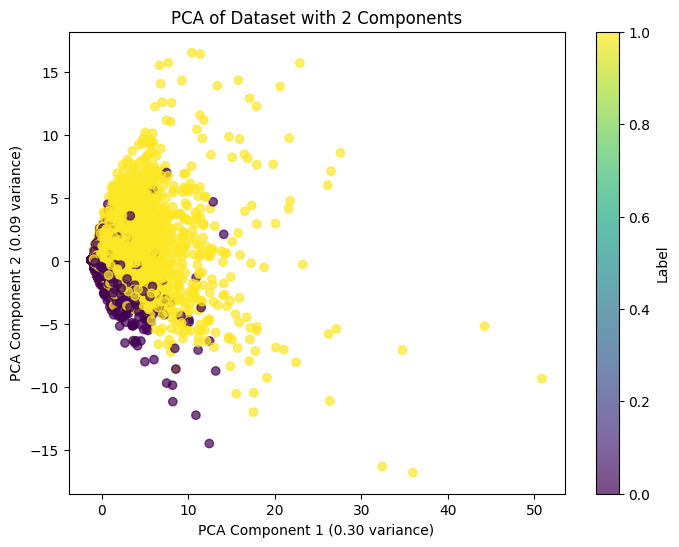

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/lemm/lem_mhc_revision_1.csv')

# Separate features and labels
X = df.drop(columns=['label'])  # Exclude the label column
y = df['label']

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Print the explained variance ratio of each component
print("Explained variance ratio for each PCA component:")
print(pca.explained_variance_ratio_)

# Plotting the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Label')

# Add labels and title
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2f} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2f} variance)')
plt.title('PCA of Dataset with 2 Components')

# Show the plot
plt.show()

Explained variance ratio for each PCA component:
[0.29956597 0.09450965 0.0824401 ]


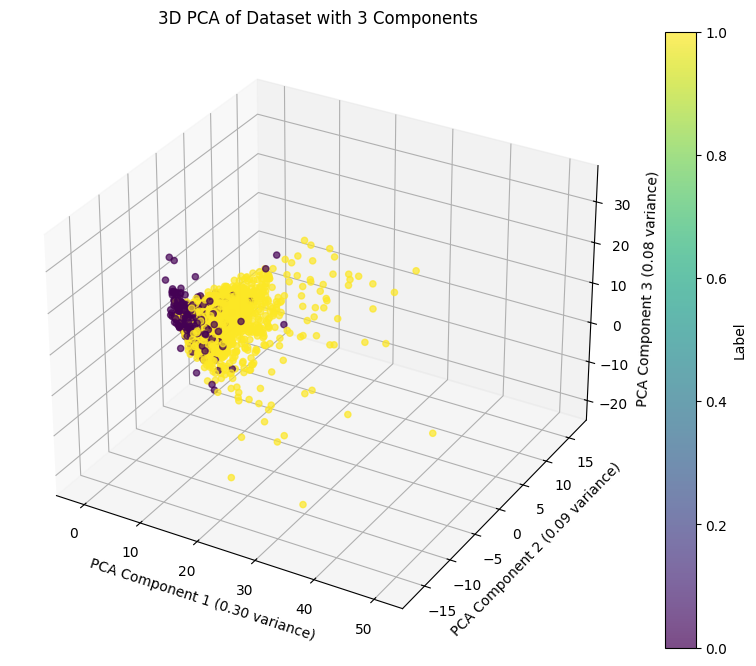

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
df = pd.read_csv('data/lemm/lem_mhc_revision_1.csv')

# Separate features and labels
X = df.drop(columns=['label'])  # Exclude the label column
y = df['label']

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Print the explained variance ratio of each component
print("Explained variance ratio for each PCA component:")
print(pca.explained_variance_ratio_)

# Plotting the PCA results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with colors based on their labels
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)

# Add color bar for labels
colorbar = fig.colorbar(scatter, ax=ax, label='Label')

# Set labels for axes
ax.set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2f} variance)')
ax.set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2f} variance)')
ax.set_zlabel(f'PCA Component 3 ({pca.explained_variance_ratio_[2]:.2f} variance)')
ax.set_title('3D PCA of Dataset with 3 Components')

# Show the plot
plt.show()